In [ ]:
#import Libraries
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50

### 1. Load the dataset

In [ ]:
#load the dataset
TRAIN_X_FILE = "images_medseg.npy"
TRAIN_Y_FILE = "masks_medseg.npy"

imgs_medseg = np.load(TRAIN_X_FILE).astype(np.float32)
msks_medseg = np.load(TRAIN_Y_FILE).astype(np.float32)

In [ ]:
# import numpy as np

# plt.style.use("dark_background")

# def visualize(image_batch, mask_batch=None, pred_batch=None, num_samples=8):
#     num_classes = mask_batch.shape[-1] if mask_batch is not None else 0
#     fix, ax = plt.subplots(num_classes + 1, num_samples, figsize=(num_samples * 2, (num_classes + 1) * 2))
#     for i in range(num_samples):
#         ax_image = ax[0, i] if num_classes > 0 else ax[i]
#         ax_image.imshow(image_batch[i,:,:,0], cmap="Greys")
#         ax_image.set_xticks([]) 
#         ax_image.set_yticks([])
        
#         if mask_batch is not None:
#             for j in range(num_classes):
#                 if pred_batch is None:
#                     mask_to_show = mask_batch[i,:,:,j]
#                 else:
#                     mask_to_show = np.zeros(shape=(*mask_batch.shape[1:-1], 3)) 
#                     mask_to_show[..., 0] = pred_batch[i,:,:,j] > 0.5
#                     mask_to_show[..., 1] = mask_batch[i,:,:,j]
#                 ax[j + 1, i].imshow(mask_to_show, vmin=0, vmax=1)
#                 ax[j + 1, i].set_xticks([]) 
#                 ax[j + 1, i].set_yticks([]) 

#     plt.tight_layout()
#     plt.show()

In [ ]:
#Normalize the data
def normalize_img(img):
    img = img.astype("float32")
    img[img > 500] = 500
    img[img < -1500] = -1500
    min_perc, max_perc = np.percentile(img, 5), np.percentile(img, 95)
    img_valid = img[(img > min_perc) & (img < max_perc)]
    mean, std = img_valid.mean(), img_valid.std()
    img = (img-mean)/std
    return img

def iou(true_y, pred_y):
    def f(true_y, pred_y):
        intersection = (true_y * pred_y).sum()
        union = true_y.sum() + pred_y.sum() - intersection
        x = (intersection)/(union)
        x = x.astype(np.float32)
        return x
    return tf.numpy_function(f, [true_y, pred_y], tf.float32)

In [ ]:
imgs_medseg = normalize_img(imgs_medseg)

#### Split training and validation data

In [ ]:
train_x, val_x, train_y, val_y = train_test_split(imgs_medseg, msks_medseg, test_size=0.1, random_state=42)

### 2. Baseline Model - UNET Architecture

In [ ]:
def convolution(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

def downsample(input, num_filters):
    x = convolution(input, num_filters)
    p = MaxPool2D((2,2))(x)
    return x, p

def upsample(input, skip_connections, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_connections])
    x = convolution(x, num_filters)
    return x

def build_unet(input_shape):
    inputs = Input(input_shape)

    sc1, p1 = downsample(inputs, 64)
    sc2, p2 = downsample(p1, 128)
    sc3, p3 = downsample(p2, 256)
    sc4, p4 = downsample(p3, 512)

    b1 = convolution(p4, 1024)

    d1 = upsample(b1, sc4, 512)
    d2 = upsample(d1, sc3, 256)
    d3 = upsample(d2, sc2, 128)
    d4 = upsample(d3, sc1, 64)

    outputs = Conv2D(4,(1,1),padding="same",activation="softmax")(d4)

    model = Model(inputs, outputs, name="U-Net")
    return model

### 2.1 Custom model - Resnet50 with UNet

In [ ]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50

def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_resnet50_unet(inputs):
    """ Input """
    # inputs = Input(input_shape)

    """ Pre-trained ResNet50 Model """
    # resnet50 = ResNet50(include_top=False, weights=None, input_tensor=inputs)

    """ Encoder """
    s1 = resnet50.get_layer("input_1").output           ## (512 x 512)
    s2 = resnet50.get_layer("conv1_relu").output        ## (256 x 256)
    s3 = resnet50.get_layer("conv2_block3_out").output  ## (128 x 128)
    s4 = resnet50.get_layer("conv3_block4_out").output  ## (64 x 64)

    """ Bridge """
    b1 = resnet50.get_layer("conv4_block6_out").output  ## (32 x 32)

    """ Decoder """
    d1 = decoder_block(b1, s4, 512)                     ## (64 x 64)
    d2 = decoder_block(d1, s3, 256)                     ## (128 x 128)
    d3 = decoder_block(d2, s2, 128)                     ## (256 x 256)
    d4 = decoder_block(d3, s1, 64)                      ## (512 x 512)

    """ Output """
    # outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)
    outputs = Conv2D(4,(1,1),padding="same",activation="softmax")(d4)

    model = Model(inputs, outputs, name="ResNet50_U-Net")
    return model


### Building Baseline Model (UNet)

In [ ]:
res_input_shape = imgs_medseg.shape[1:]
res_inputs = Input(res_input_shape)

resnet50 = ResNet50(include_top=False, weights=None, input_shape=res_input_shape, input_tensor=res_inputs)

unet = build_unet(imgs_medseg.shape[1:])
unet.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["acc", iou])


2023-04-28 10:13:13.398824: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-28 10:13:13.973188: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11560 MB memory:  -> device: 0, name: Tesla K80, pci bus id: 0001:00:00.0, compute capability: 3.7


### Building Custom Model (ResNet50 with UNet)

In [ ]:
resunet_model = build_resnet50_unet(res_inputs)
resunet_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["acc", iou])

### Train Baseline Model (requires GPU)

In [ ]:
results = unet.fit(train_x, train_y, validation_data=(val_x, val_y), epochs=50, batch_size=2, verbose=1)

Epoch 1/50


2023-04-28 10:13:32.673433: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8700
2023-04-28 10:13:33.232655: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


45/45 [==============================] - 90s 2s/step - loss: 0.7062 - acc: 0.7706 - iou: 0.4536 - val_loss: 16806.7344 - val_acc: 0.0397 - val_iou: 0.0199
Epoch 2/50
45/45 [==============================] - 71s 2s/step - loss: 0.4515 - acc: 0.8369 - iou: 0.5770 - val_loss: 644.3636 - val_acc: 0.1289 - val_iou: 0.0618
Epoch 3/50
45/45 [==============================] - 72s 2s/step - loss: 0.4109 - acc: 0.8623 - iou: 0.6391 - val_loss: 65.0213 - val_acc: 0.1491 - val_iou: 0.0775
Epoch 4/50
45/45 [==============================] - 72s 2s/step - loss: 0.3784 - acc: 0.8768 - iou: 0.6760 - val_loss: 12.1059 - val_acc: 0.4086 - val_iou: 0.2516
Epoch 5/50
45/45 [==============================] - 72s 2s/step - loss: 0.3117 - acc: 0.8908 - iou: 0.7130 - val_loss: 10.0500 - val_acc: 0.2141 - val_iou: 0.1114
Epoch 6/50
45/45 [==============================] - 72s 2s/step - loss: 0.3472 - acc: 0.8767 - iou: 0.6930 - val_loss: 3.0805 - val_acc: 0.4316 - val_iou: 0.2710
Epoch 7/50
45/45 [============

#### Training Analytics

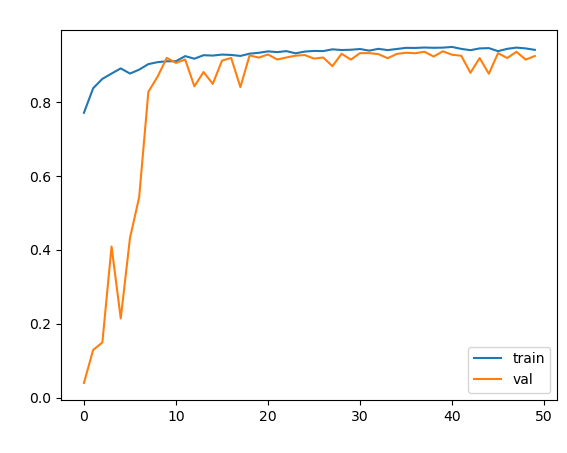

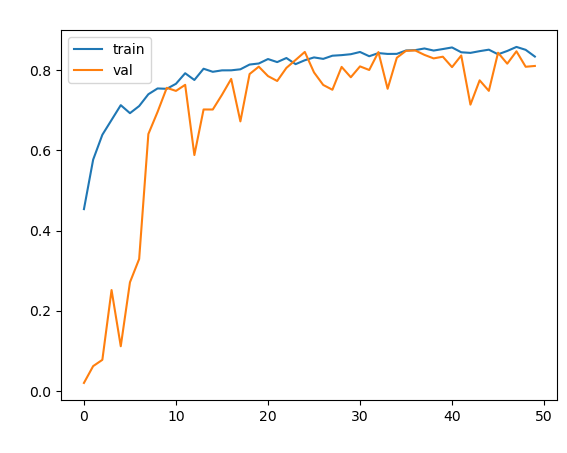

In [ ]:
plt.figure(0)
plt.plot(results.history["acc"])
plt.plot(results.history["val_acc"])
plt.title("Training vs Validation Accuracy", color="white")

plt.xlabel("epoch", color="white")
plt.ylabel("accuracy", color="white")
plt.legend(["train", "val"])
plt.show()

plt.figure(1)
plt.plot(results.history["iou"])
plt.plot(results.history["val_iou"])
plt.title("Training vs Validation IoU", color="white")

plt.xlabel("epoch", color="white")
plt.ylabel("IoU", color="white")
plt.legend(["train", "val"])
plt.show()

#### Segmented Output for Ground Glass

In [ ]:
def plot_hists(images):
    plt.hist(images.ravel(), bins=100, density=True, color='b', alpha=1)

(10, 512, 512, 4)


<Figure size 640x480 with 0 Axes>

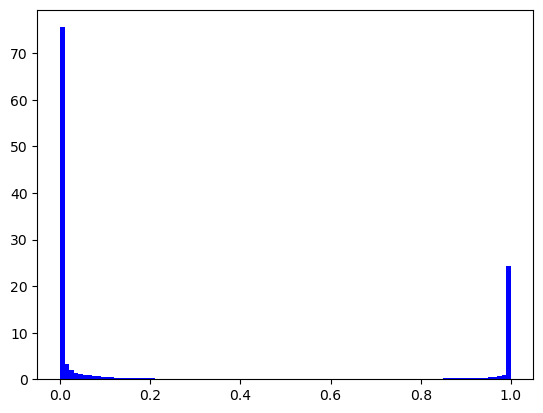

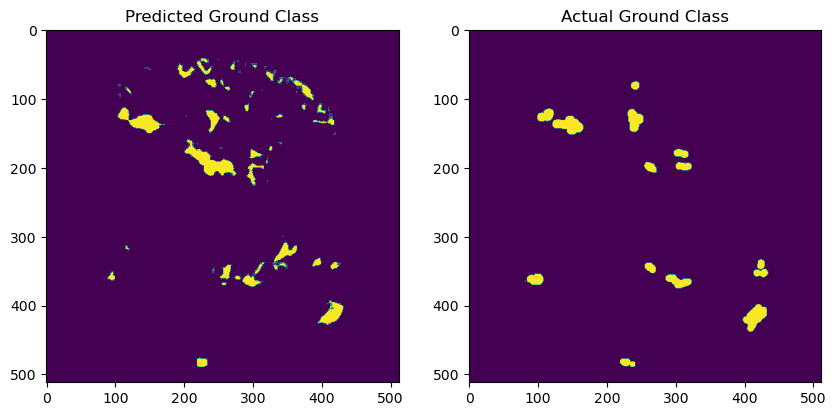

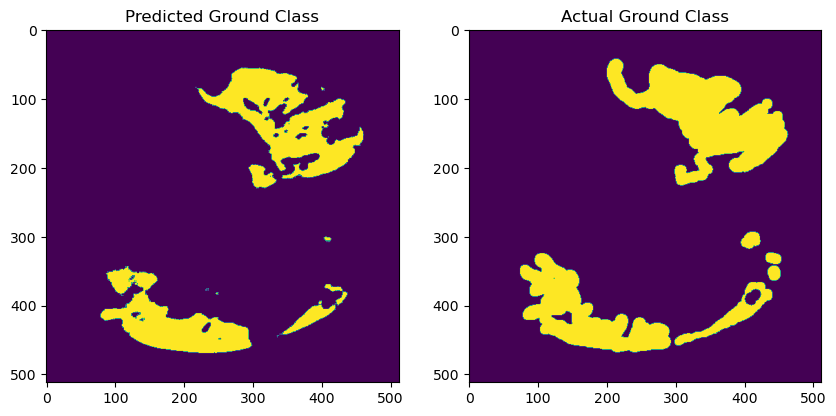

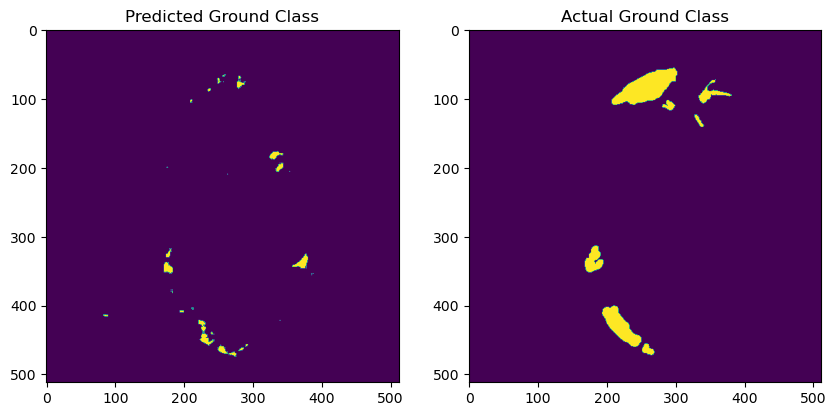

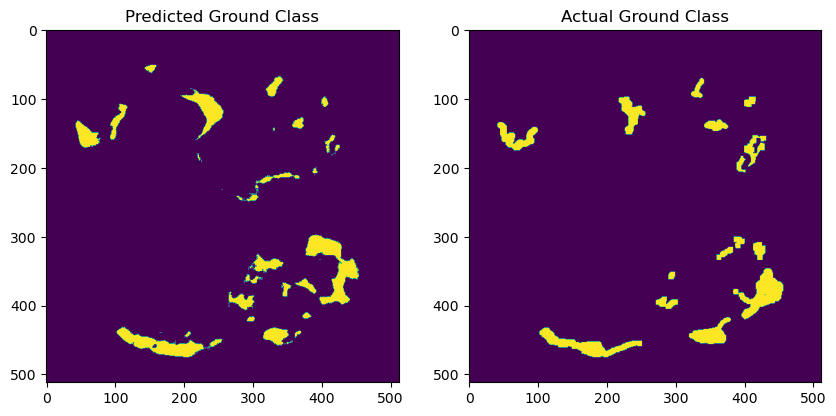

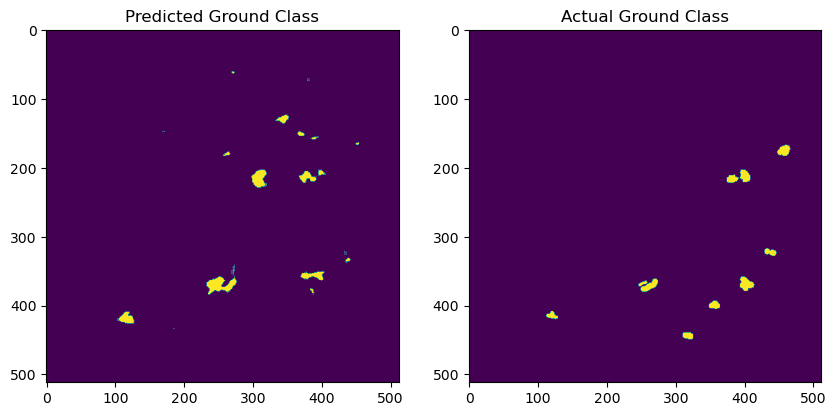

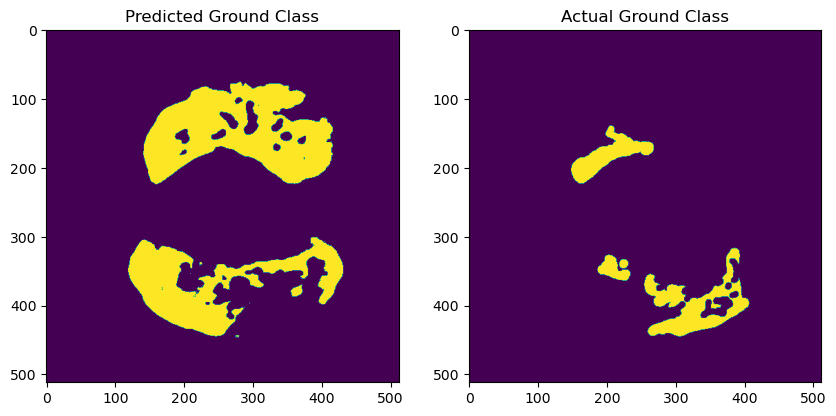

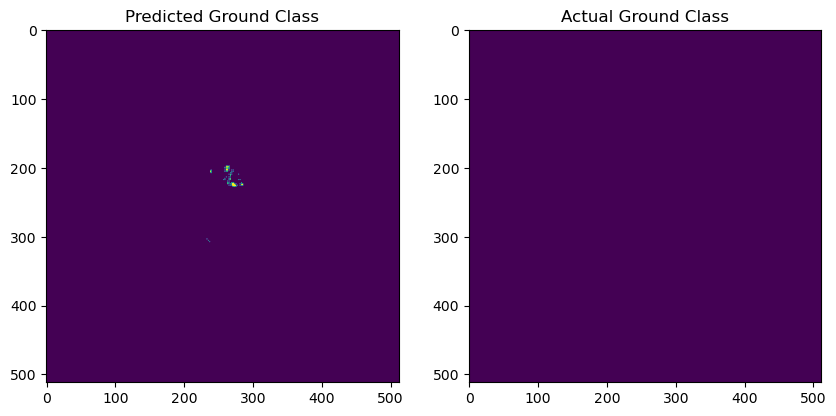

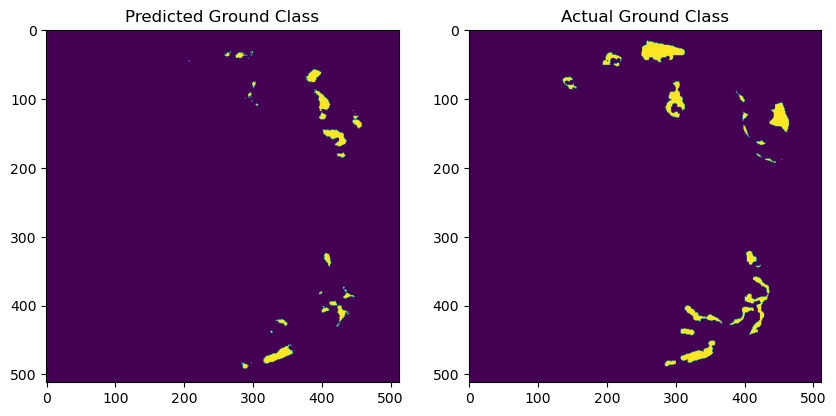

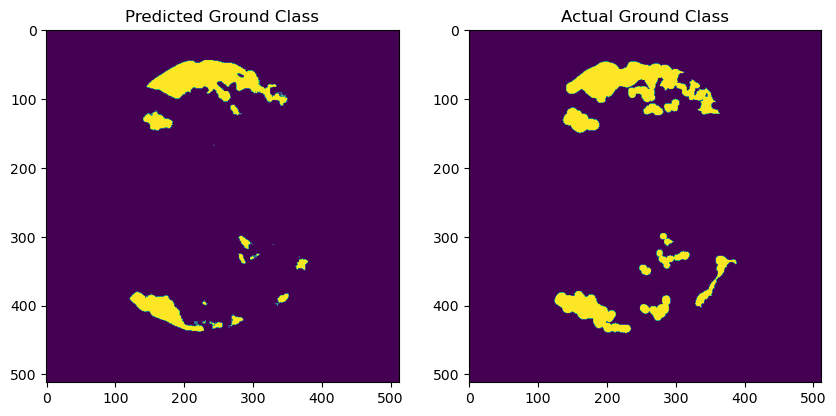

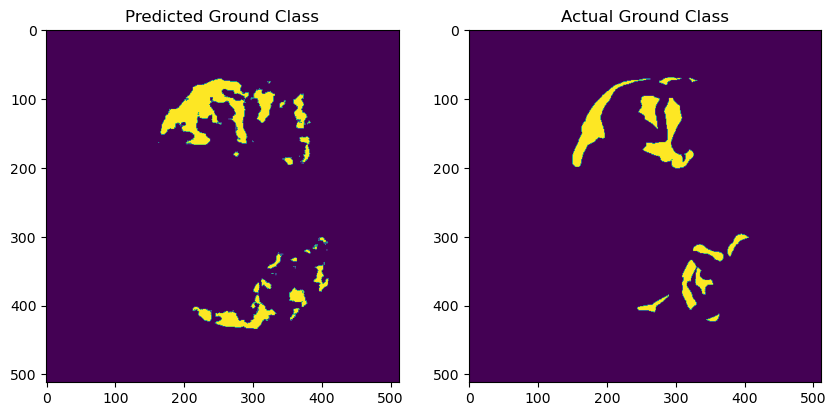

In [ ]:
pred_y = unet.predict(val_x)
plot_hists(pred_y)

def filter_pixels(img):
    for i in range(img.shape[0]):
        for j in range(img.shape[3]):
            for k in range(img.shape[1]):
                for l in range(img.shape[2]):
                    img[i,k,l,j] = 1 if (img[i,k,l,j] > 0.5) else 0;
    return img

pred_y = filter_pixels(pred_y)
plot_hists(pred_y)

print(pred_y.shape)
for i in range(0, 10):
    plt.figure(i)
    fig, ax = plt.subplots(1,2, figsize=(10,10))
    ax[0].imshow(pred_y[i,:,:,0])
    ax[0].title.set_text("Predicted Ground Class")
    ax[1].imshow(val_y[i,:,:,0])
    ax[1].title.set_text("Actual Ground Class")

### Train Custom Model (ResNet50 with UNet) - requires GPU

In [ ]:
resunet_results = resunet_model.fit(train_x, train_y, validation_data=(val_x, val_y), epochs=50, batch_size=2, verbose=1)

Epoch 1/50
45/45 [==============================] - 62s 1s/step - loss: 0.6392 - acc: 0.7814 - iou: 0.4967 - val_loss: 3.8757 - val_acc: 0.2643 - val_iou: 0.1132
Epoch 2/50
45/45 [==============================] - 52s 1s/step - loss: 0.4347 - acc: 0.8434 - iou: 0.6231 - val_loss: 12.5468 - val_acc: 0.3708 - val_iou: 0.2183
Epoch 3/50
45/45 [==============================] - 52s 1s/step - loss: 0.3261 - acc: 0.8856 - iou: 0.6912 - val_loss: 4.6492 - val_acc: 0.2698 - val_iou: 0.1557
Epoch 4/50
45/45 [==============================] - 52s 1s/step - loss: 0.2967 - acc: 0.8973 - iou: 0.7259 - val_loss: 0.7494 - val_acc: 0.7448 - val_iou: 0.5940
Epoch 5/50
45/45 [==============================] - 52s 1s/step - loss: 0.2641 - acc: 0.9125 - iou: 0.7608 - val_loss: 1.9131 - val_acc: 0.6507 - val_iou: 0.4569
Epoch 6/50
45/45 [==============================] - 53s 1s/step - loss: 0.2805 - acc: 0.9039 - iou: 0.7478 - val_loss: 8.6547 - val_acc: 0.5889 - val_iou: 0.4085
Epoch 7/50
45/45 [=========

#### Training Analytics

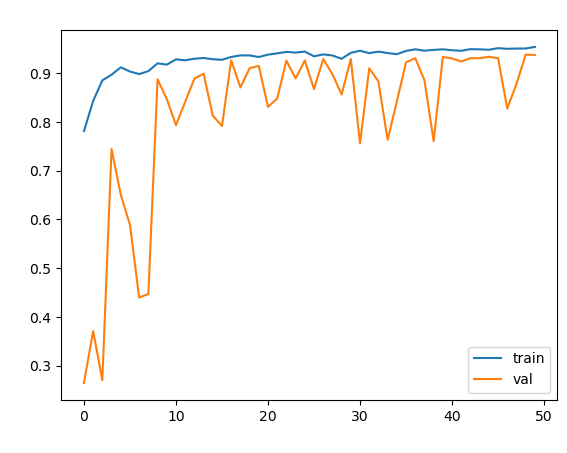

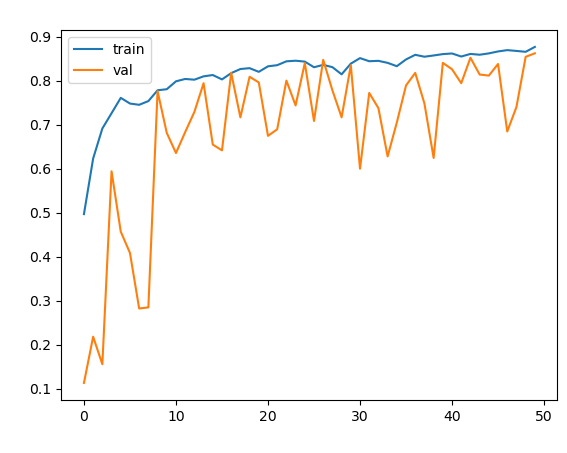

In [ ]:
plt.figure(0)
plt.plot(resunet_results.history["acc"])
plt.plot(resunet_results.history["val_acc"])
plt.title("Training vs Validation Accuracy", color="white")

plt.xlabel("epoch", color="white")
plt.ylabel("accuracy", color="white")
plt.legend(["train", "val"])
plt.show()

plt.figure(1)
plt.plot(resunet_results.history["iou"])
plt.plot(resunet_results.history["val_iou"])
plt.title("Training vs Validation IoU", color="white")

plt.xlabel("epoch", color="white")
plt.ylabel("IoU", color="white")
plt.legend(["train", "val"])
plt.show()

#### Segmented Output for Ground Glass

(10, 512, 512, 4)


<Figure size 640x480 with 0 Axes>

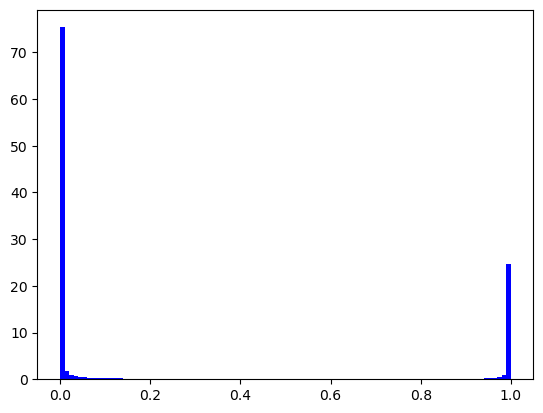

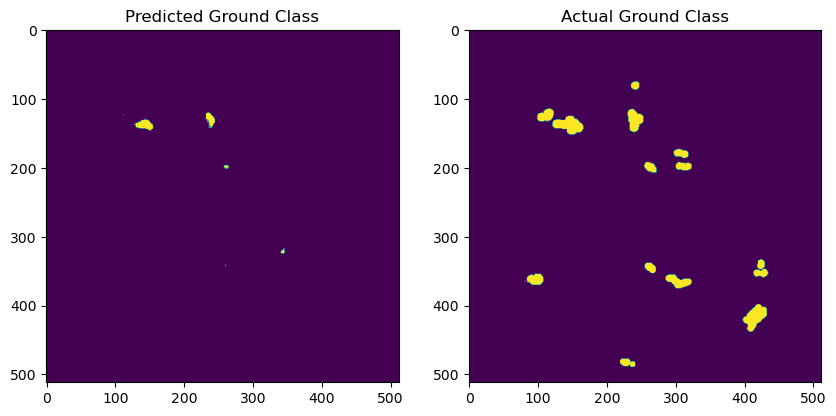

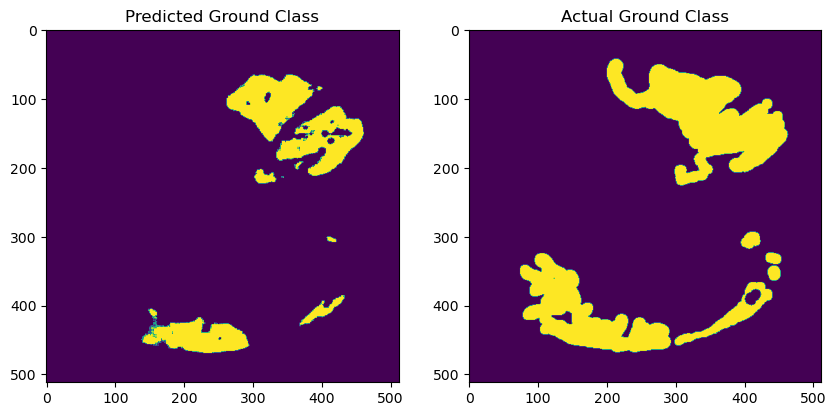

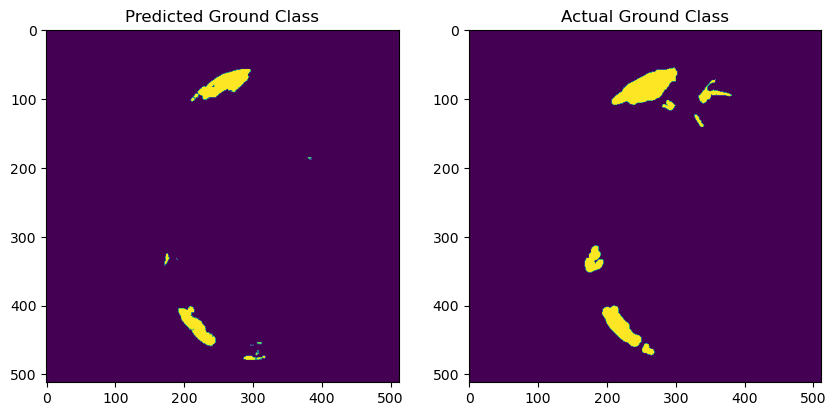

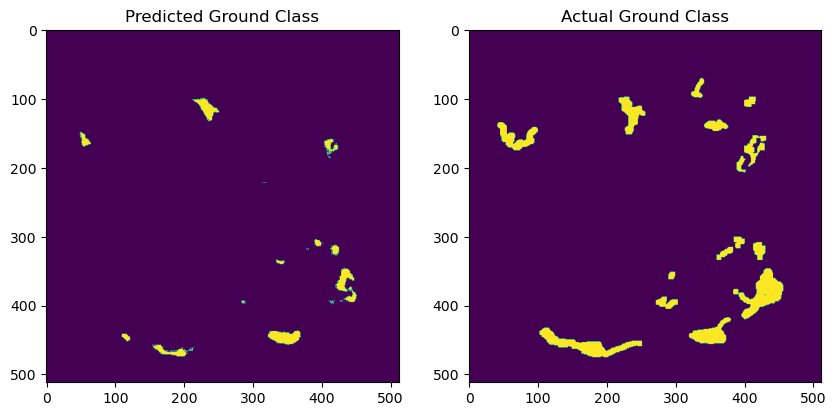

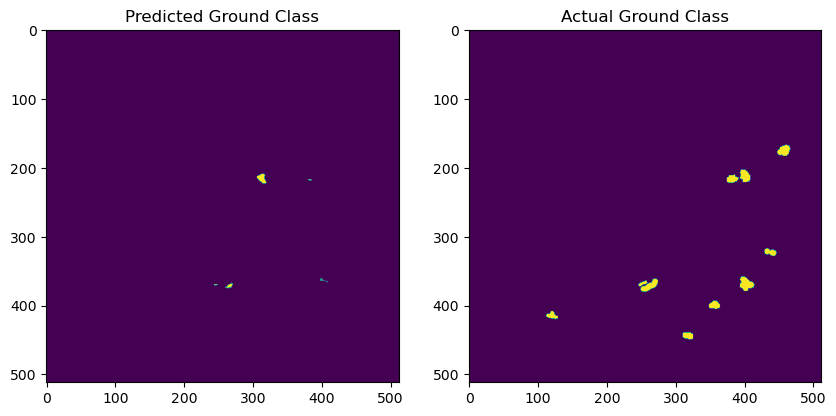

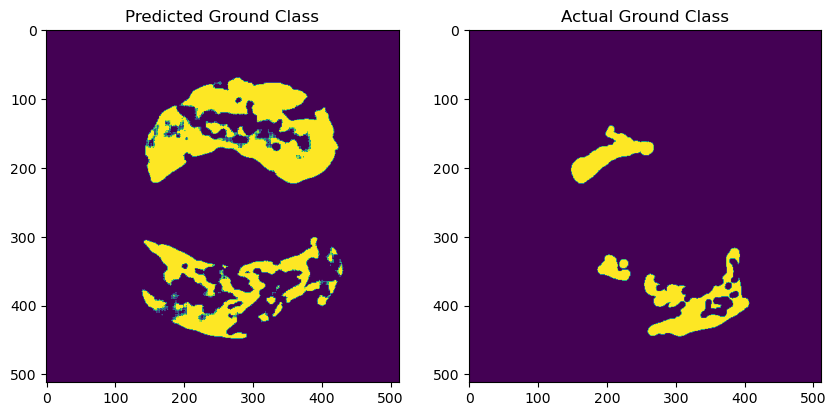

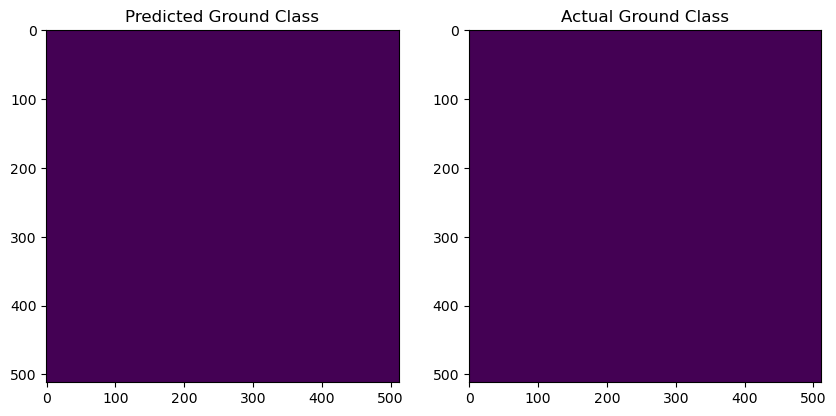

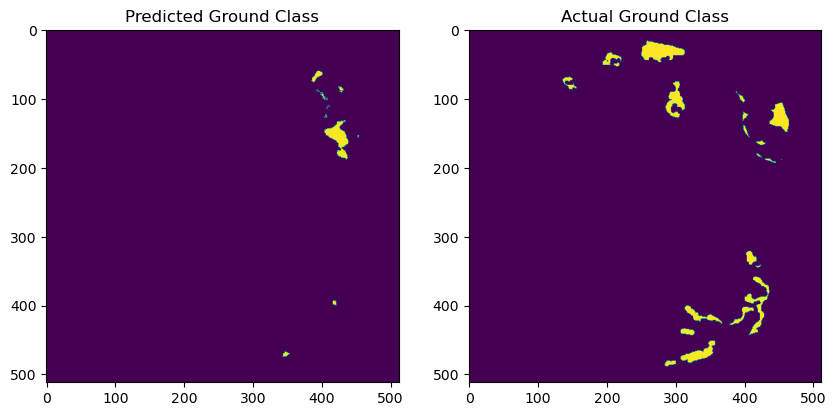

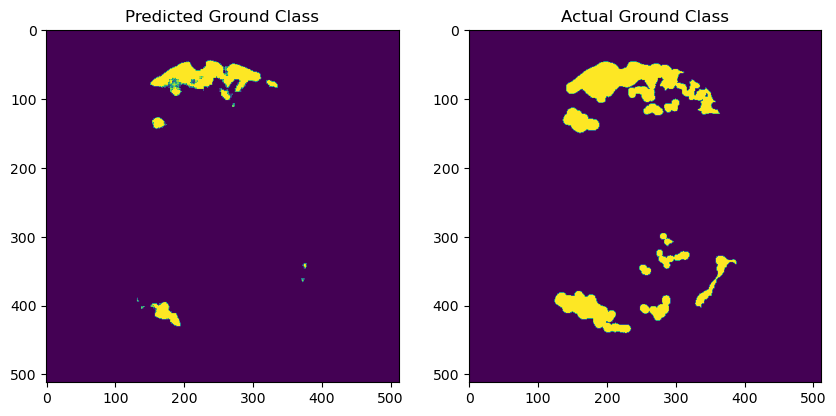

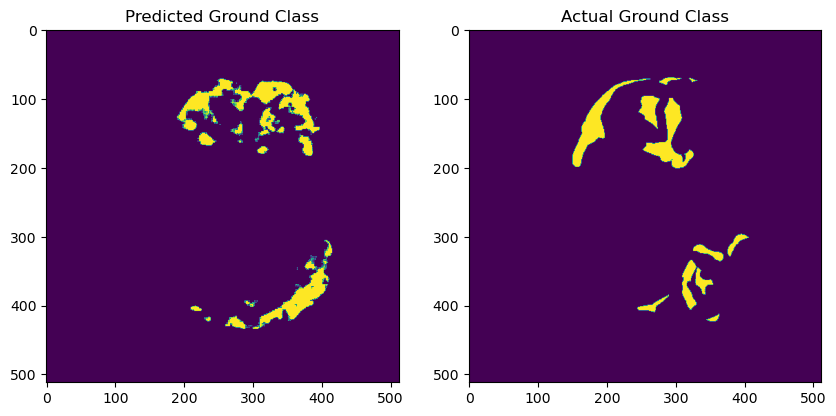

In [ ]:
pred_y = resunet_model.predict(val_x)
plot_hists(pred_y)

def filter_pixels(img):
    for i in range(img.shape[0]):
        for j in range(img.shape[3]):
            for k in range(img.shape[1]):
                for l in range(img.shape[2]):
                    img[i,k,l,j] = 1 if (img[i,k,l,j] > 0.5) else 0;
    return img

pred_y = filter_pixels(pred_y)
plot_hists(pred_y)

print(pred_y.shape)
for i in range(0, 10):
    plt.figure(i)
    fig, ax = plt.subplots(1,2, figsize=(10,10))
    ax[0].imshow(pred_y[i,:,:,0])
    ax[0].title.set_text("Predicted Ground Class")
    ax[1].imshow(val_y[i,:,:,0])
    ax[1].title.set_text("Actual Ground Class")